In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
import matplotlib
import datetime
import numpy as np
import itertools
import warnings

## old implemention

In [47]:
def initial_trend_old(series, slen):
    _sum = 0.0
    for i in range(slen):
        _sum += float(series[i+slen] - series[i]) / slen
    return _sum / slen

def initial_seasonal_components_old(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing_old(series,n_preds, slen, alpha, beta, gamma, ):
    result = []
    seasonals = initial_seasonal_components_old(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend_old(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    print(seasonals)
    return result

 # cuurent implemention

In [8]:
def initial_trend(series, slenArray):
    # the trend is the average difference in values between season one and season two
    _sum = 0.0
    slen=slenArray[0]
    for i in range(slen):
        _sum += float(series[i+slen] - series[i]) / slen
    return _sum / slen

def initial_seasonal_components(series,slenArray,seasonMode):
    seasonals = [{}]
    season_averages = []
    
    slen=slenArray[0]
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    if "additive" in seasonMode:
        init_values = 0
        opeartion_function = lambda a,b:a-b
    elif "multiplicative" in seasonMode:
        init_values = 1
        opeartion_function = lambda a,b:a/b
    else:
        raise ValueError(f"unknown season mode {seasonMode}")    
        
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += opeartion_function(series[slen*j+i],season_averages[j])
        seasonals[0][i] = sum_of_vals_over_avg/n_seasons
    
    for i in range(1,len(slenArray)):
        #n_seasons = int(len(series)/slenArray[i])
        seasonals.append({})
        for j in range(slenArray[i]):
            seasonals[i][j]=init_values
    #print(seasonals)
    return seasonals

def computeSeason(i,seasonals,slenArray,seasonMode):
    if  "additive" in seasonMode:
        totalSeasons = 0
        function = lambda a,b: a+b
    elif "multiplicative" in seasonMode:
        totalSeasons = 1
        function = lambda a,b: a*b
    else:
        raise ValueError(f"unknown season mode {seasonMode}")
    #
    for seasonIndex in range(len(slenArray)):
        slen=slenArray[seasonIndex]
        totalSeasons = function(totalSeasons,seasonals[seasonIndex][i%slen])
    return totalSeasons


def updateSeason(gamma,seasonals,current_val,last_smmoth_n_trend,i,slenArray,seasonMode):
    total=computeSeason(i,seasonals,slenArray,seasonMode)
    
    for seasonIndex in range(len(slenArray)):
        
        slen=slenArray[seasonIndex]
        if  "additive" in seasonMode:
            value = total-seasonals[seasonIndex][i%slen]
            seasonals[seasonIndex][i%slen] = gamma*(current_val-last_smmoth_n_trend-value) + (1-gamma)*seasonals[seasonIndex][i%slen]
            
        elif  "multiplicative" in seasonMode:
            value = total/seasonals[seasonIndex][i%slen]
            # adding the max func was a guess of mine what to do.
            seasonals[seasonIndex][i%slen] = gamma*(current_val/(last_smmoth_n_trend*value)) + (1-gamma)*seasonals[seasonIndex][i%slen] 

        else:
            raise ValueError(f"unknown season mode {seasonMode}")
        
    return seasonals


def forecast(smooth,m,trend,totalSeasons,seasonMode,includeTrend):
    value = smooth
    if includeTrend:
        value += m*trend
    if  "additive" in seasonMode:
         return value + totalSeasons
    elif "multiplicative" in seasonMode:
         return value * totalSeasons
    else:
        raise ValueError(f"unknown season mode {seasonMode}")
    

def smoothVal(alpha,last_smooth,current_val,last_trend,totalSeasons,seasonMode,includeTrend):
    past=last_smooth
    if includeTrend:
        past+=last_trend
    if  "additive" in seasonMode:
        return alpha*(current_val-totalSeasons) + (1-alpha)*(past)
    elif  "multiplicative" in seasonMode:
        d = alpha*(current_val/totalSeasons) + (1-alpha)*(past)
        return d
    else:
        raise ValueError(f"unknown season mode {seasonMode}")

        
def triple_exponential_smoothing(series, n_preds, slenArray, alpha, beta, gamma,seasonMode="additive",includeTrend=True):
    result = []
    
    seasonals = initial_seasonal_components(series, slenArray,seasonMode)
    
    for i in range(len(series)+n_preds):
        
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slenArray)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            totalSeasons = computeSeason(i,seasonals,slenArray,seasonMode)
            result.append(forecast(smooth,m,trend,totalSeasons,seasonMode,includeTrend))
        else:
            val = series[i]
            #
            totalSeasons = computeSeason(i,seasonals,slenArray,seasonMode)
            #
            last_smooth, smooth = smooth, smoothVal(alpha,smooth,val,trend,totalSeasons,seasonMode,includeTrend)             
            last_trend,trend =trend , beta * (smooth-last_smooth) + (1-beta)*trend
            # update season
            seasonals = updateSeason(gamma,seasonals,val,smooth,i,slenArray,seasonMode)
            # update values
            totalSeasons = computeSeason(i,seasonals,slenArray,seasonMode) 
            # add
            result.append(forecast(smooth,1,trend,totalSeasons,seasonMode,includeTrend)) 
    return result,seasonals

## stat models like implemention

In [9]:
def initial_trend_stat(series, slenArray):
    # the trend is the average difference in values between season one and season two
    _sum = 0.0
    slen=slenArray[0]
    for i in range(slen):
        _sum += float(series[i+slen] - series[i]) / slen
    return _sum / slen

def initial_level_stat(series,slen):
    sum_of_vals_over_avg = 0.0
    #n_seasons = math.ceil(len(series)/slen)
    
    j = 0
    while slen*j < len(series):
        sum_of_vals_over_avg += series[slen*j]
        j+=1
    return sum_of_vals_over_avg/j
        
def initial_seasonal_components_stat(series,slenArray,seasonMode,smooth_null):
    seasonals = [{}]
    season_averages = []
    
    slen=slenArray[0]
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
        
    if "additive" in seasonMode:
        init_values = 0
        opeartion_function = lambda a,b:a-b
    elif "multiplicative" in seasonMode:
        init_values = 1
        opeartion_function = lambda a,b:a/b
    else:
        raise ValueError(f"unknown season mode {seasonMode}")    
        
    # compute initial values
    for i in range(slen):
        seasonals[0][i] = opeartion_function(series[i],smooth_null)
    
    for i in range(1,len(slenArray)):
        seasonals.append({})
        for j in range(slenArray[i]):
            seasonals[i][j]=init_values
    #print(seasonals)
    return seasonals

def computeSeason_stat(i,seasonals,slenArray,seasonMode):
    if  "additive" in seasonMode:
        totalSeasons = 0
        function = lambda a,b: a+b
    elif "multiplicative" in seasonMode:
        totalSeasons = 1
        function = lambda a,b: a*b
    else:
        raise ValueError(f"unknown season mode {seasonMode}")
    #
    for seasonIndex in range(len(slenArray)):
        slen=slenArray[seasonIndex]
        totalSeasons = function(totalSeasons,seasonals[seasonIndex][i%slen])
    return totalSeasons


def updateSeason_stat(gamma,seasonals,current_val,last_smmoth_n_trend,i,slenArray,seasonMode):
    total=computeSeason_stat(i,seasonals,slenArray,seasonMode)
    
    for seasonIndex in range(len(slenArray)):
        
        slen=slenArray[seasonIndex]
        if  "additive" in seasonMode:
            value = total-seasonals[seasonIndex][i%slen]
            seasonals[seasonIndex][i%slen] = gamma*(current_val-last_smmoth_n_trend-value) + (1-gamma)*seasonals[seasonIndex][i%slen]
            
        elif  "multiplicative" in seasonMode:
            value = total/seasonals[seasonIndex][i%slen]
            # adding the max func was a guess of mine what to do.
            seasonals[seasonIndex][i%slen] = gamma*(current_val/(last_smmoth_n_trend*value)) + (1-gamma)*seasonals[seasonIndex][i%slen] 

        else:
            raise ValueError(f"unknown season mode {seasonMode}")
        
    return seasonals


def forecast_stat(smooth,m,trend,totalSeasons,seasonMode,includeTrend):
    value=smooth
    if includeTrend:
        value+=m*trend
    if  "additive" in seasonMode:
         return value + totalSeasons
    elif "multiplicative" in seasonMode:
         return value * totalSeasons
    else:
        raise ValueError(f"unknown season mode {seasonMode}")
    

def smoothVal_stat(alpha,last_smooth,current_val,last_trend,totalSeasons,seasonMode,includeTrend):
    past=last_smooth
    if includeTrend:
        past+=last_trend
    if  "additive" in seasonMode:
        return alpha*(current_val-totalSeasons) + (1-alpha)*(past)
    elif  "multiplicative" in seasonMode:
        return alpha*(current_val/totalSeasons) + (1-alpha)*(past)
    else:
        raise ValueError(f"unknown season mode {seasonMode}")

        
def triple_exponential_smoothing_stat(series, n_preds, slenArray, alpha, beta, gamma, seasonMode="additive",includeTrend=True):
    result = []
    smooth = initial_level_stat(series,slenArray[0])
    trend = initial_trend(series, slenArray)
    seasonals = initial_seasonal_components_stat(series, slenArray,seasonMode,smooth)
    print(f"seasonals {seasonals}")
    for i in range(len(series)+n_preds):
        #print(i)
        if i == 0: # initial values
            totalSeasons = computeSeason_stat(i,seasonals,slenArray,seasonMode)-trend
            print(totalSeasons,end=",")
            result.append(smooth+totalSeasons)
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            totalSeasons = computeSeason_stat(i,seasonals,slenArray,seasonMode)
            result.append(forecast_stat(smooth,m,trend,totalSeasons,seasonMode,includeTrend))
        else:
            val = series[i]
            #
            totalSeasons = computeSeason_stat(i,seasonals,slenArray,seasonMode)
            #
            print(totalSeasons,end=",")
            last_smooth, smooth = smooth, smoothVal_stat(alpha,smooth,val,trend,totalSeasons,seasonMode,includeTrend)             
            _,trend = trend , beta * (smooth-last_smooth) + (1-beta)*trend
            # update season
            seasonals = updateSeason_stat(gamma,seasonals,val,smooth,i,slenArray,seasonMode)
            # update values
            totalSeasons = computeSeason_stat(i,seasonals,slenArray,seasonMode) 
            # 
            result.append(forecast_stat(smooth,1,trend,totalSeasons,seasonMode,includeTrend)) 
    return result,seasonals

In [10]:
new_series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

{0: -0.8578481695178931, 1: -0.6017482325494633, 2: -0.2576966686997352, 3: 0.1137028544693706, 4: 0.4470351687401727, 5: 0.6835830022834763, 6: 0.7816579247722559, 7: 0.7239351738582556, 8: 0.5205018448906282, 9: 0.20708213311305496, 10: -0.16124811444389792, 11: -0.5197516518768045, 12: -0.80541995206984, 13: -0.9680591681741654, 14: -0.9490904243567324, 15: -0.98086715370554}


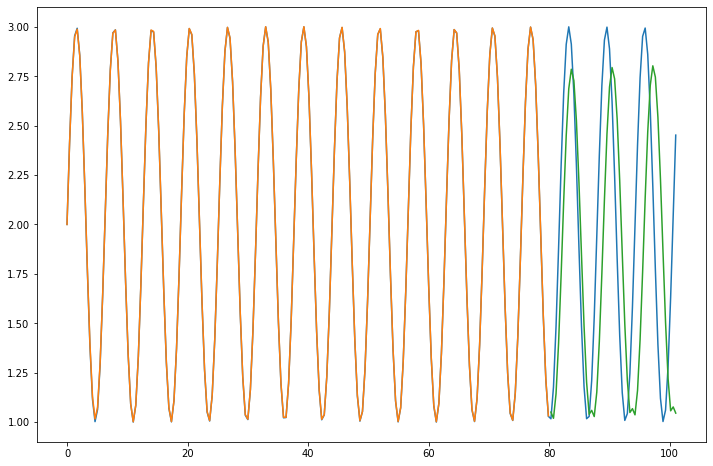

In [48]:
x = np.linspace(0, 101, 16*15) 
y = np.sin(x) + 2
_y = triple_exponential_smoothing_old(y.tolist()[:-50],50, 16,0.1,0.005,0.99)

import matplotlib.pylab as plt
plt.figure(figsize=(12,8)) 
plt.plot(x, y)
plt.plot(x[:-50], _y[:-50])
plt.plot(x[-50:], _y[-50:])

plt.show()

# Compare to old implemention 

In [6]:
gap= 0.1
h=20
for alpha,beta,gamma in zip(np.arange(0, 1.0+gap, gap),np.arange(0, 1.0+gap, gap),np.arange(0, 1.0+gap, gap)):
    old_forecast=triple_exponential_smoothing_old(new_series,h, 7,  alpha,beta,gamma)[-h:]
    new_forecast=triple_exponential_smoothing(new_series,h, [7], alpha,beta,gamma,seasonMode="additive",includeTrend=True)[0][-h:]
    np.testing.assert_array_equal(new_forecast,old_forecast)

# Compare to stat model

In [7]:
def stat_model_holtwinters(series,alpha,beta,gamma,h,season_length=7,seasonal_type="multiplicative",includeTrend=True):
    if includeTrend:
        trend_type="add"
    else:
        trend_type=None
        
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    model = ExponentialSmoothing(series,trend=trend_type,seasonal_periods=season_length,seasonal=seasonal_type)
    # fit model
    model_fit = model.fit(smoothing_level=alpha,smoothing_slope=beta,damping_slope=0,smoothing_seasonal=gamma,use_brute=False,optimized=False,use_boxcox=False,remove_bias=False,use_basinhopping=False)
    # make one step forecast
    smoothenTrue=model_fit.predict(h)

    
    return model_fit#,smoothenTrue

 # Define Grid Search

# Lets try it

In [8]:
units_to_forecast=20
gap=0.8
in_options={"alpha":np.arange(gap, min(1.0+gap,1), gap),
            "beta": np.arange(gap, min(1.0+gap,1),gap), 
            "gamma":np.arange(gap, min(1.0+gap,1),gap),
            "seasonMode":["additive"],
            "includeTrend":[True],
            "slenArray":[[12]]
             }
in_options

{'alpha': array([0.8]),
 'beta': array([0.8]),
 'gamma': array([0.8]),
 'seasonMode': ['additive'],
 'includeTrend': [True],
 'slenArray': [[12]]}

In [11]:
from utils import map_to_configuration_list,grid_search,handle_scores
#

#
options = map_to_configuration_list(in_options)
#
fold_size = int(0.1*len(new_series))
all_results = grid_search(triple_exponential_smoothing,new_series,options,mean_absolute_error,fold_size,1)
best_fit_score, best_fit = handle_scores(all_results,options)
#
import matplotlib.pyplot as plt
# plotting the Series
plt.plot(new_series[-units_to_forecast:], label = "Truth")
# plotting the Series
plt.plot(triple_exponential_smoothing(new_series,units_to_forecast,**best_fit)[0][-units_to_forecast:], label = best_fit)

# giving a title to the graph
plt.title('Forecast with GridSearch')
# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Series Values')

plt.grid(True)


# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

KeyboardInterrupt: 

# plot all

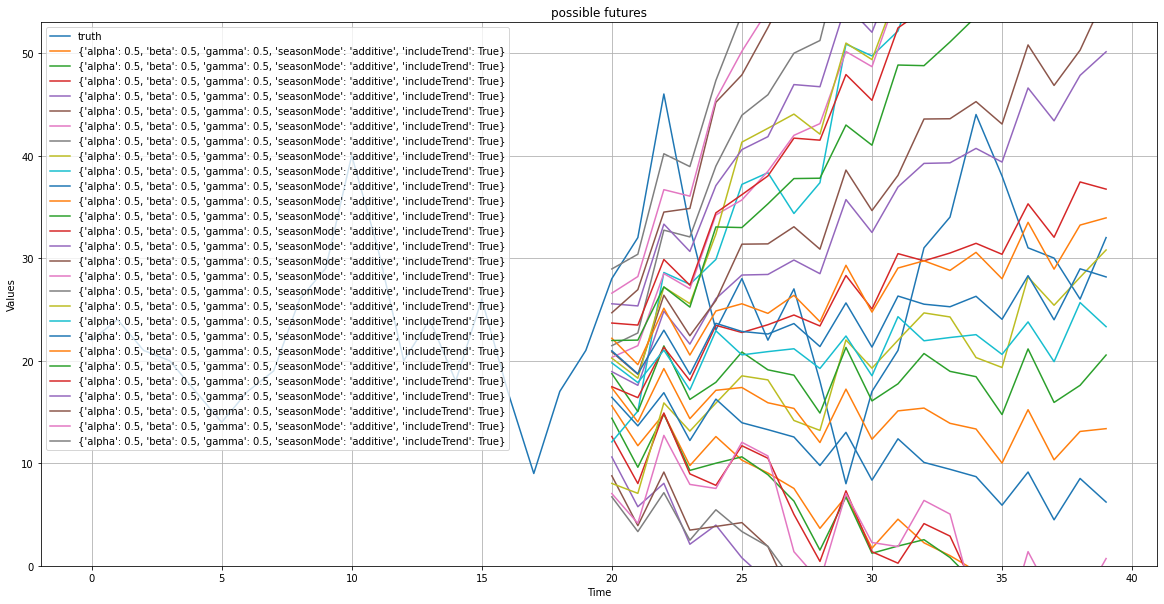

In [85]:
current_series=new_series
#
units_to_forecast=20
gap=0.25
in_options={"alpha":np.arange(gap, min(1.0+gap,1.0), gap),
            "beta": np.arange(gap, min(1.0+gap,1.0),gap), 
            "gamma":np.arange(gap, min(1.0+gap,1.0),gap),
            "seasonMode":["additive"],
            "includeTrend":[True],
            "slenArray":[[7]]
             }

options = map_to_configuration_list(in_options)

#
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

# plotting the Series
series_to_plot = current_series[-2*units_to_forecast:]
plt.plot(series_to_plot, label = "truth")

# plotting the Series
for single_option in options:
    #
    forecasted=triple_exponential_smoothing(current_series[:-units_to_forecast],units_to_forecast,**single_option)[0]
    plt.plot(np.add(range(units_to_forecast), len(series_to_plot)-units_to_forecast).tolist(), forecasted[-units_to_forecast:], label = best_list)
    


# giving a title to the graph
plt.title('possible futures')
# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Values')

plt.grid(True)

# setting x and y axis range
plt.ylim(0,max(current_series))
#plt.xlim(0,100)

# show a legend on the plot
plt.legend()

# function to show the plot
plt.show()

# make sure the error rate goes down as we deeper the search

In [ ]:
# #
# units_to_forecast=20
# show_from=-40

# def range_with_gap(gap,starting=0):
#     return np.arange(starting, 1.0+gap, gap)

# params_options= [
#             {"alpha":range_with_gap(0.1),
#             "beta": range_with_gap(0.1), 
#             "gamma":range_with_gap(0.1),
#             "seasonMode":["multiplicative","additive"],
#             "includeTrend":[True,False],
#             "slen":[[7]]
#              }
#             ,
#             {"alpha":range_with_gap(0.05),
#             "beta": range_with_gap(0.05), 
#             "gamma":range_with_gap(0.05),
#             "seasonMode":["multiplicative","additive"],
#             "includeTrend":[True,False],
#             "slen":[[7]]
#              }
#             ,
#             {"alpha":range_with_gap(0.025),
#             "beta": range_with_gap(0.025), 
#             "gamma":range_with_gap(0.025),
#             "seasonMode":["multiplicative","additive"],
#             "includeTrend":[True,False],
#             "slen":[[7]]
#              }
#             ,
#             {"alpha":range_with_gap(0.0125),
#             "beta": range_with_gap(0.0125), 
#             "gamma":range_with_gap(0.0125),
#             "seasonMode":["multiplicative","additive"],
#             "includeTrend":[True,False],
#             "slen":[[7]]
#              }
#          ]

# options=list(itertools.product(*in_options.values()))
# ds="AGE ## Gave Caller Information <in> Kaggle___Department_Abbreviation____Call_Resolution__"

# import matplotlib.pyplot as plt

# errors={}
# preds={}
# selected_param={}
# for params in params_options:
#     values_selected,mae,train,pred,test=train_and_predict(ds,params,None,mean_absolute_error,write_result=False)
#     print(values_selected)
#     errors[str(params)]=mae
#     preds[str(params)]=pred[:units_to_forecast]
#     selected_param[str(params)]=values_selected

# plt.rcParams["figure.figsize"] = (20,3)
# test=test[:units_to_forecast]
# train=train[-40:]
# plt.plot(list(range(len(train))),train, label = "train")
# plt.plot(list(range(len(train),len(train)+len(test))),test, label = "test")
# for key in preds.keys():
#     plt.plot(list(range(len(train),len(train)+len(test))),preds[key], label = str(selected_param[key]))
# plt.title('Visual compare')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.grid(True)
# plt.legend()
# plt.show()
    

# plt.plot(list(errors.values()), label = "Errors")
# plt.title('Error rate')
# plt.xlabel('Time')
# plt.ylabel('MAE')
# plt.grid(True)
# plt.legend()
# plt.show()